# ⚛️ H₂ Excited States via SSVQE (Pure Package Client)

This notebook computes the **ground state (E₀)** and the **first excited state (E₁)**
of the hydrogen molecule **H₂** using a **Subspace-Search VQE (SSVQE)** workflow via the package.

**Package-first goals**
- Use the canonical API: `vqe.ssvqe.run_ssvqe(...)`
- Plot convergence via: `vqe.visualize.plot_ssvqe_convergence_multi(...)`
- Reconstruct optimized states via: `vqe.engine.make_state_qnode(...)`
- Save all plots to `images/vqe/` via `vqe_qpe_common.plotting.save_plot(..., kind="vqe", show=True)`

## 1️⃣ Imports & Setup

In [ ]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

from vqe.ssvqe import run_ssvqe
from vqe.hamiltonian import build_hamiltonian
from vqe.ansatz import get_ansatz
from vqe.engine import make_device, make_state_qnode
from vqe.visualize import plot_ssvqe_convergence_multi

from vqe_qpe_common.plotting import save_plot, build_filename

# Reproducibility
np.random.seed(0)

## 2️⃣ Run Configuration

In [2]:
molecule = "H2"

num_states = 2
penalty_weight = 10.0

ansatz_name = "UCCSD"
optimizer_name = "Adam"

steps = 250
stepsize = 0.2
seed = 0

print("Molecule:", molecule)
print("States:  ", num_states)
print("Ansatz:  ", ansatz_name)
print("Opt:     ", optimizer_name)
print("Steps:   ", steps)
print("LR:      ", stepsize)
print("Seed:    ", seed)
print("Penalty: ", penalty_weight)

Molecule: H2
States:   2
Ansatz:   UCCSD
Opt:      Adam
Steps:    250
LR:       0.2
Seed:     0
Penalty:  10.0


## 3️⃣ Run SSVQE via the Package API

In [3]:
result = run_ssvqe(
    molecule=molecule,
    num_states=num_states,
    penalty_weight=penalty_weight,
    ansatz_name=ansatz_name,
    optimizer_name=optimizer_name,
    steps=steps,
    stepsize=stepsize,
    seed=seed,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    plot=False,   # notebook controls plotting explicitly
    force=False,
)

energies_per_state = result["energies_per_state"]
final_params = result["final_params"]

print("\nFinal energies:")
for k, traj in enumerate(energies_per_state):
    print(f"  State {k}: E = {traj[-1]:.8f} Ha")

💾 Saved SSVQE run to /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__SSVQE(UCCSD)_2states__Adam__SSVQE__noiseless__s0__83b63cb5f676.json

Final energies:
  State 0: E = -1.13534519 Ha
  State 1: E = -0.35309711 Ha


## 4️⃣ Convergence Plot (Saved to `images/vqe/`)

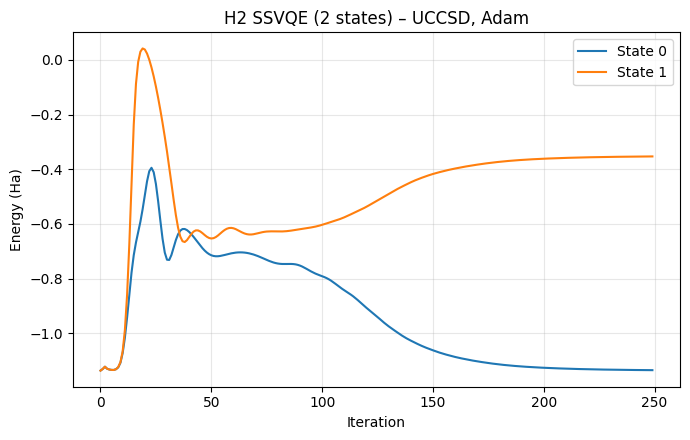

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_ssvqe_convergence_states2_ansUCCSD_optAdam.png


In [4]:
plot_ssvqe_convergence_multi(
    energies_per_state=energies_per_state,
    molecule=molecule,
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    show=True,
    save=True,
)

## 5️⃣ Excitation Gap

In [5]:
E0_final = float(energies_per_state[0][-1])
E1_final = float(energies_per_state[1][-1]) if len(energies_per_state) > 1 else float("nan")
delta_E = E1_final - E0_final

print(f"\n{molecule} — SSVQE Results ({ansatz_name}, {optimizer_name})")
print(f"E₀ (ground)  = {E0_final:.8f} Ha")
print(f"E₁ (excited) = {E1_final:.8f} Ha")
print(f"ΔE = E₁ - E₀  = {delta_E:.8f} Ha")


H2 — SSVQE Results (UCCSD, Adam)
E₀ (ground)  = -1.13534519 Ha
E₁ (excited) = -0.35309711 Ha
ΔE = E₁ - E₀  = 0.78224808 Ha


## 6️⃣ Statevector Analysis: Basis-State Amplitudes (Saved to `images/vqe/`)

We reconstruct the optimized states using `vqe.engine.make_state_qnode(...)`
and plot significant basis-state amplitudes for both eigenstates.

In [6]:
# Rebuild molecule data (kept explicit for robustness)
H, num_qubits, symbols, coordinates, basis = build_hamiltonian(molecule)

dev = make_device(num_qubits, noisy=False)
ansatz_fn = get_ansatz(ansatz_name)

state_qnode = make_state_qnode(
    dev,
    ansatz_fn,
    num_qubits,
    noisy=False,
    depolarizing_prob=0.0,
    amplitude_damping_prob=0.0,
    symbols=symbols,
    coordinates=coordinates,
    basis=basis,
)

params0 = np.array(final_params[0])
params1 = np.array(final_params[1])

psi0 = state_qnode(params0)
psi1 = state_qnode(params1)

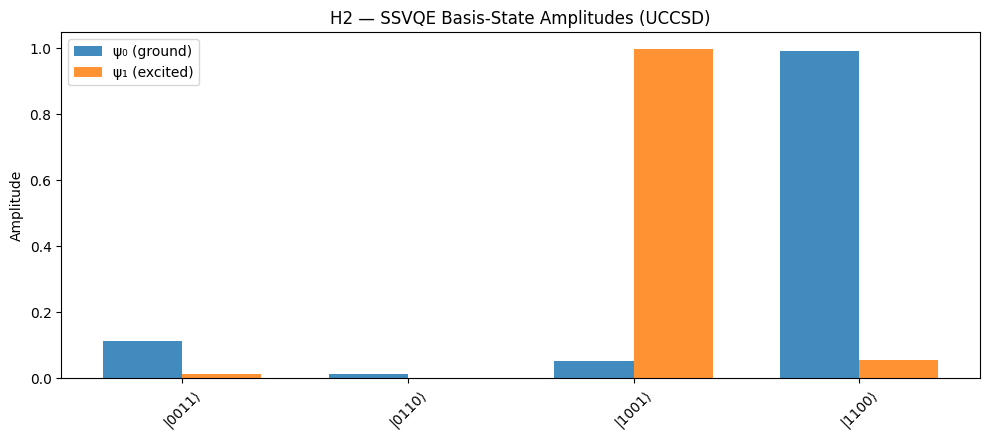

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_ssvqe_basis_state_amplitudes_ansUCCSD_optAdam_states2.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H2_ssvqe_basis_state_amplitudes_ansUCCSD_optAdam_states2.png'

In [7]:
threshold = 1e-2
indices = np.unique(np.where((np.abs(psi0) > threshold) | (np.abs(psi1) > threshold))[0])

labels = [f"|{i:0{num_qubits}b}⟩" for i in indices]
amp0 = np.abs([psi0[i] for i in indices])
amp1 = np.abs([psi1[i] for i in indices])

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 4.5))
plt.bar(x - width / 2, amp0, width, alpha=0.85, label="ψ₀ (ground)")
plt.bar(x + width / 2, amp1, width, alpha=0.85, label="ψ₁ (excited)")
plt.xticks(x, labels, rotation=45)
plt.ylabel("Amplitude")
plt.title(f"{molecule} — SSVQE Basis-State Amplitudes ({ansatz_name})")
plt.legend()
plt.tight_layout()

fname = build_filename(
    molecule=molecule,
    topic="ssvqe_basis_state_amplitudes",
    extras={"ans": ansatz_name, "opt": optimizer_name, "states": num_states},
)
save_plot(fname, kind="vqe", show=True)

## ✅ Summary

- Ran **SSVQE** for **H₂** using the packaged API: `vqe.ssvqe.run_ssvqe`.
- Plotted multi-state convergence via `vqe.visualize.plot_ssvqe_convergence_multi`.
- Reconstructed optimized statevectors and saved a basis-amplitudes plot to `images/vqe/`.